In [2]:
!pip install pandas_datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 2.6 MB/s eta 0:00:00a 0:00:01


In [6]:
import pandas as pd
import numpy as np

# 1) Load SPY prices
spy = pd.read_csv("SPY.csv", parse_dates=["Date"], index_col="Date")["Close"]

# 2) Compute daily log returns
returns = np.log(spy).diff().dropna()

# 3) Compute forward 1-year realized volatility (252 trading days)
window = 252
rv1y_forward = (
    returns.shift(-1)
           .rolling(window)
           .std()
           .mul(np.sqrt(window))
           .dropna()
           .rename("RV1Y_forward")
)

# 4) Load VIX1Y (1-year implied vol)
vix1y = (
    pd.read_csv("VIX1Y.csv", parse_dates=["DATE"], infer_datetime_format=True)
      .set_index("DATE")["CLOSE"]
      .rename("VIX1Y")
)

# 5) EWMA volatility function
def ewma_vol(returns, half_life):
    lam = np.exp(np.log(0.5) / half_life)
    alpha = 1 - lam
    return np.sqrt(returns.pow(2).ewm(alpha=alpha).mean() * window)

# 6) Compute EWMA vols
ewma21  = ewma_vol(returns,  21).rename("EWMA21")
ewma63  = ewma_vol(returns,  63).rename("EWMA63")
ewma252 = ewma_vol(returns, 252).rename("EWMA252")

# 7) Combine features and target into one DataFrame
df = pd.concat([vix1y, ewma21, ewma63, ewma252, rv1y_forward], axis=1).dropna()

# 8) Preview the combined DataFrame
print(df.head())

            VIX1Y    EWMA21    EWMA63   EWMA252  RV1Y_forward
2023-06-20  21.51  0.131336  0.172239  0.201789      0.197860
2023-06-21  21.38  0.130019  0.171506  0.201557      0.196396
2023-06-22  21.25  0.128306  0.170670  0.201303      0.196554
2023-06-23  21.41  0.128059  0.170201  0.201125      0.196397
2023-06-26  21.44  0.126506  0.169404  0.200878      0.194243


/var/folders/db/szp_swds3lx0knb7l6gsp3pm0000gn/T/ipykernel_44238/1154038779.py:23: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pd.read_csv("VIX1Y.csv", parse_dates=["DATE"], infer_datetime_format=True)


In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# 0) Ensure df is defined as before, with 5 columns and Date index

# 1) Train / test hold-out
horizon = 252
X = df[['VIX1Y','EWMA21','EWMA63','EWMA252']].values
y = df['RV1Y_forward'].values
X_train, X_test = X[:-horizon], X[-horizon:]
y_train, y_test = y[:-horizon], y[-horizon:]

# 2) Plain OLS
from sklearn.linear_model import LinearRegression
ols = LinearRegression().fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))

# 3) LassoCV with time-series CV **without** forcing test_size
tscv = TimeSeriesSplit(n_splits=5)    # default splits, no test_size parameter
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 0, 50),
    cv=tscv,
    max_iter=5000
).fit(X_train, y_train)

y_pred_lasso = lasso_cv.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

# 4) Results
pd.DataFrame({
    'Model': ['OLS', 'Lasso (CV)'],
    'RMSE': [rmse_ols, rmse_lasso],
    'Alpha (Lasso)': [np.nan, lasso_cv.alpha_]
})

,Model,RMSE,Alpha (Lasso)
0,OLS,0.059095,NaN
1,Lasso (CV),0.026458,0.0001


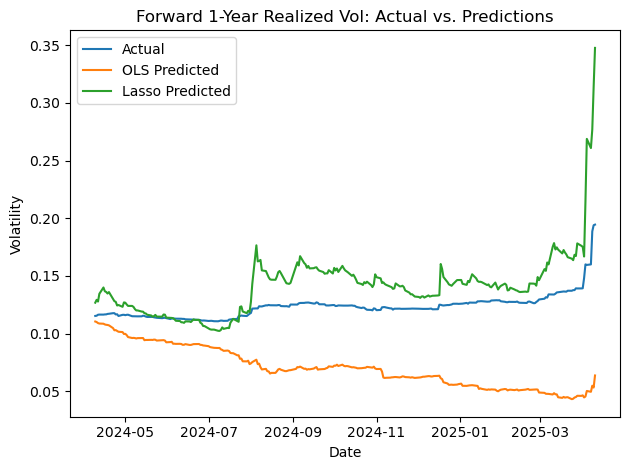

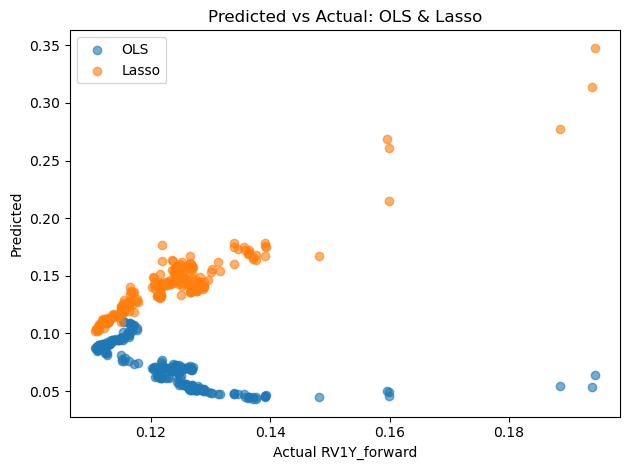

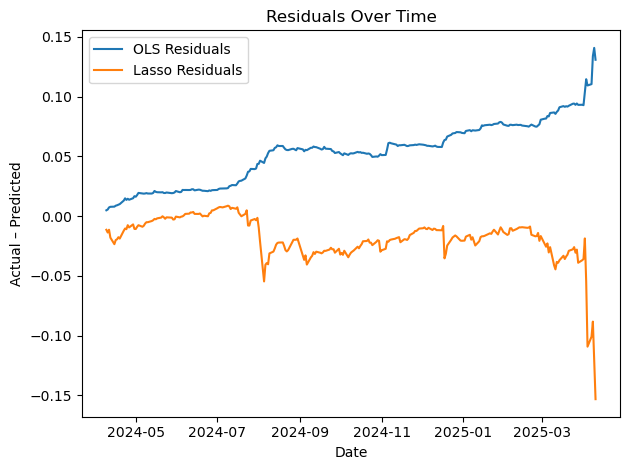

<Figure size 640x480 with 0 Axes>

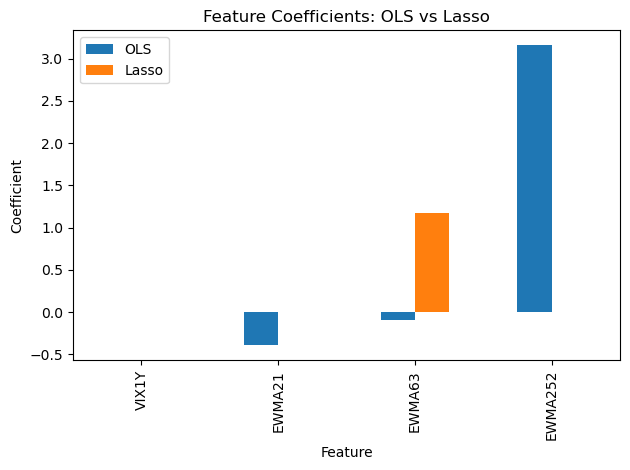

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -------------------------------------------------------------------
# ASSUMED VARIABLES:
# df              /* your full DataFrame, indexed by Date */
# horizon         /* your integer test horizon, e.g. 252 */
# ols             /* fitted LinearRegression() */
# lasso_cv        /* fitted LassoCV() */
# X_test, y_test  /* hold-out arrays */
# y_pred_ols      /* ols.predict(X_test) */
# y_pred_lasso    /* lasso_cv.predict(X_test) */
# -------------------------------------------------------------------

# 1) Build a small DataFrame of test‐set actuals & preds
test_index = df.index[-horizon:]
results_df = pd.DataFrame({
    'Actual':      y_test,
    'OLS Pred':    y_pred_ols,
    'Lasso Pred':  y_pred_lasso
}, index=test_index)

# 2) Time series plot
plt.figure()
plt.plot(results_df.index, results_df['Actual'],    label='Actual')
plt.plot(results_df.index, results_df['OLS Pred'],  label='OLS Predicted')
plt.plot(results_df.index, results_df['Lasso Pred'],label='Lasso Predicted')
plt.title('Forward 1-Year Realized Vol: Actual vs. Predictions')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()

# 3) Scatter: Predicted vs Actual
plt.figure()
plt.scatter(results_df['Actual'], results_df['OLS Pred'],  label='OLS',   alpha=0.6)
plt.scatter(results_df['Actual'], results_df['Lasso Pred'],label='Lasso', alpha=0.6)
plt.title('Predicted vs Actual: OLS & Lasso')
plt.xlabel('Actual RV1Y_forward')
plt.ylabel('Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# 4) Residuals over time
plt.figure()
plt.plot(results_df.index, results_df['Actual'] - results_df['OLS Pred'],  label='OLS Residuals')
plt.plot(results_df.index, results_df['Actual'] - results_df['Lasso Pred'],label='Lasso Residuals')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Actual – Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# 5) Coefficient comparison
coef_df = pd.DataFrame({
    'OLS':   ols.coef_,
    'Lasso': lasso_cv.coef_
}, index=['VIX1Y','EWMA21','EWMA63','EWMA252'])

plt.figure()
coef_df.plot(kind='bar')
plt.title('Feature Coefficients: OLS vs Lasso')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# 1. Assume your dataframe is already defined as 'data'
# and has these columns: VIX1Y, EWMA21, EWMA63, EWMA252, RV1Y_forward

# 2. Drop any missing values to be safe
data = df.dropna()

# 3. Set up predictors (X) and target (y)
X = data[["VIX1Y", "EWMA21", "EWMA63", "EWMA252"]]
y = data["RV1Y_forward"]

# 4. Fit SARIMAX model on this data
model = SARIMAX(
    endog=y,
    exog=X,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 5),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)

# 5. Summarize results
print(results.summary())

# 6. Predict over the same time period
y_pred = results.predict(start=y.index[0], end=y.index[-1], exog=X)

# 7. Calculate RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Test RMSE: {rmse:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                      RV1Y_forward   No. Observations:                  454
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood                2142.713
Date:                           Sun, 27 Apr 2025   AIC                          -4267.426
Time:                                   23:09:23   BIC                          -4230.503
Sample:                                        0   HQIC                         -4252.869
                                           - 454                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
VIX1Y          0.0010      0.000      9.812      0.000       0.001       0.001
EWMA21        -0.8201      0.069    -11.930

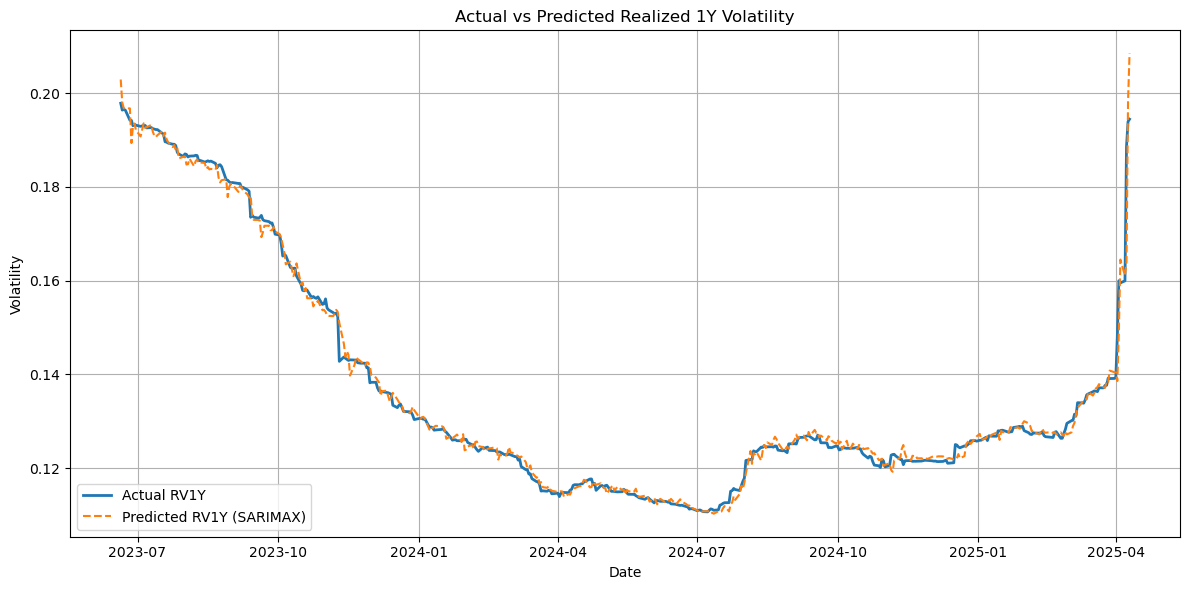

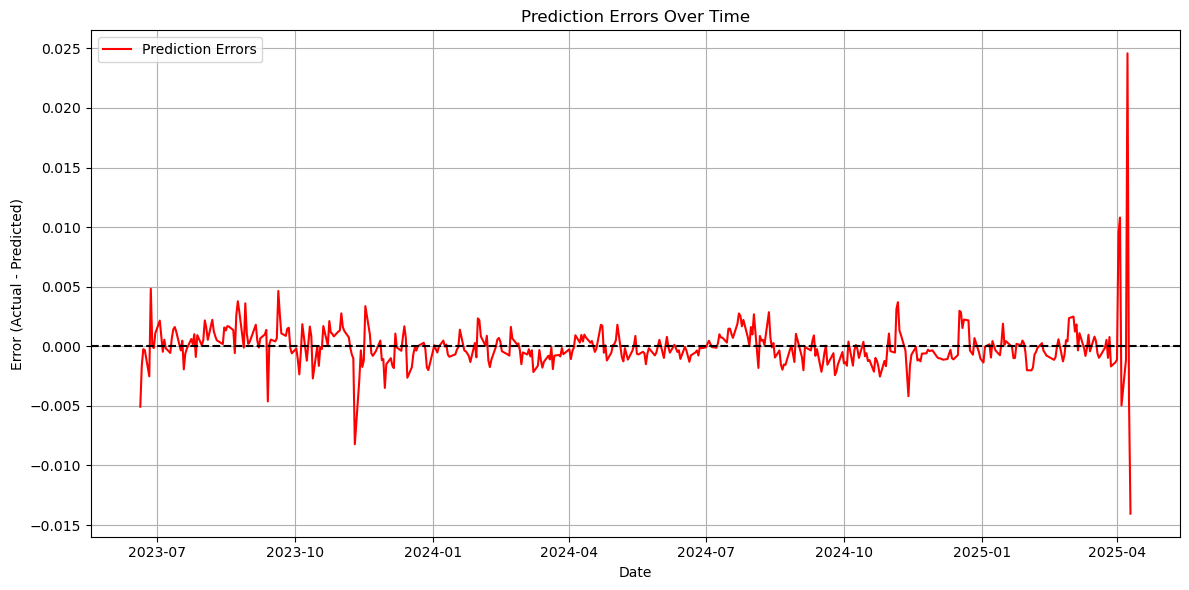

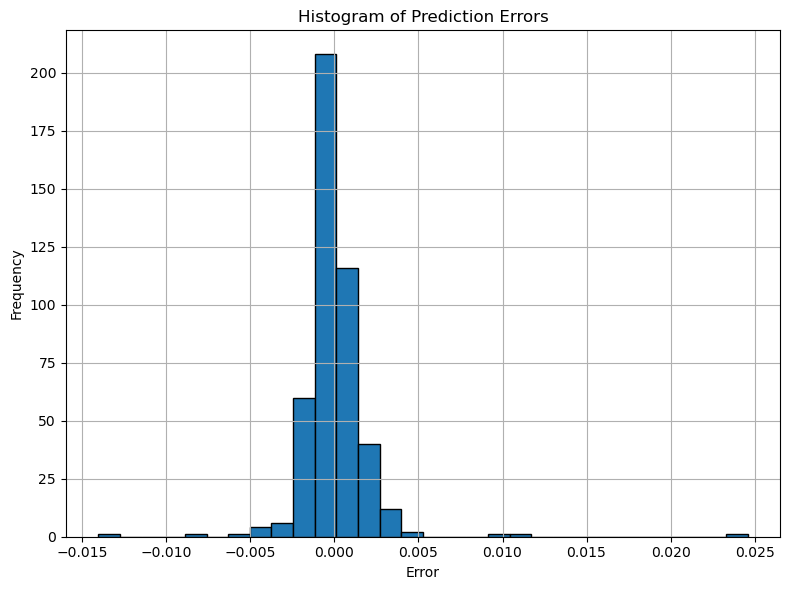

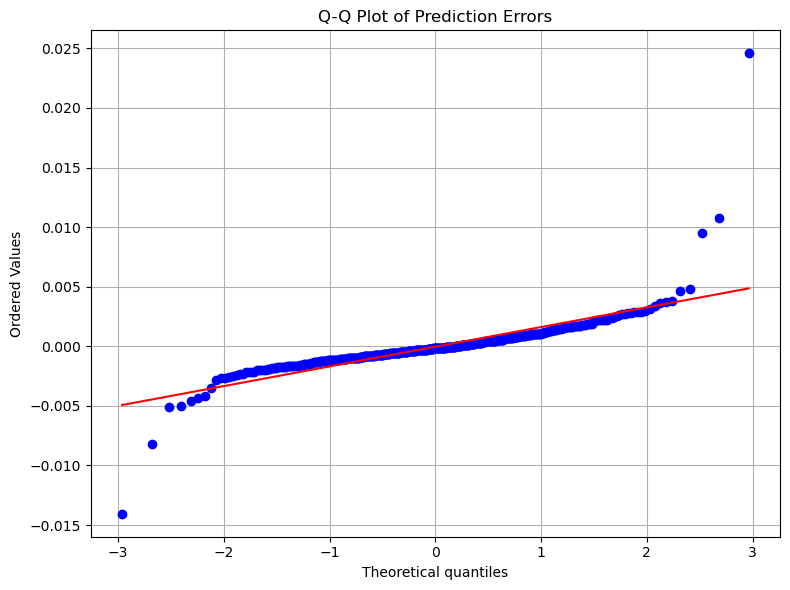

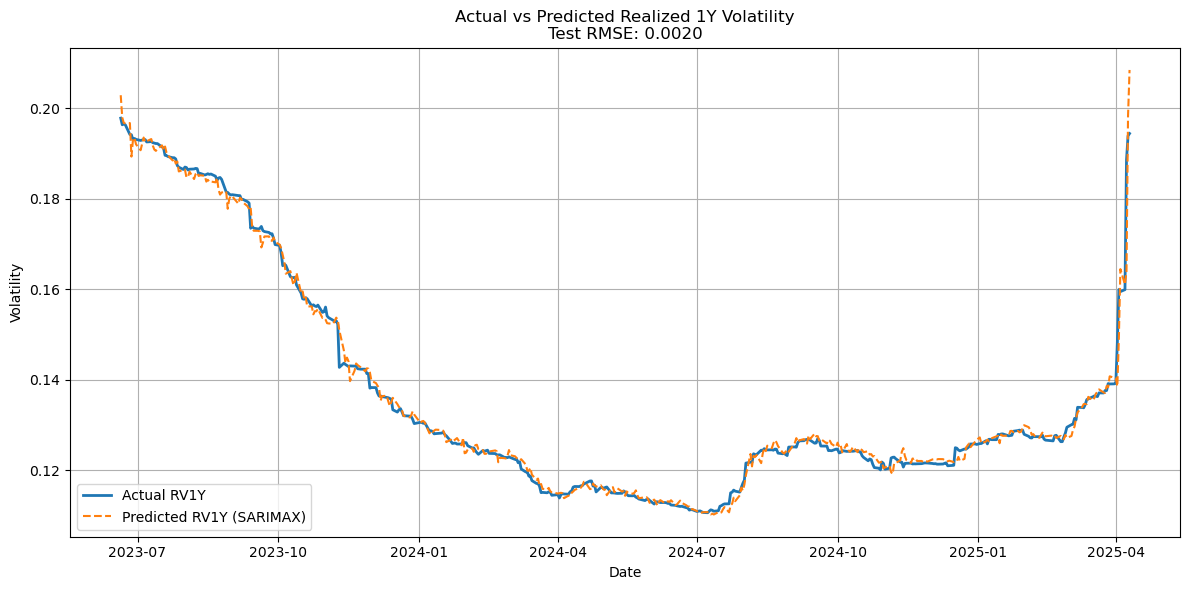

In [17]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RV1Y", linewidth=2)
plt.plot(y.index, y_pred, label="Predicted RV1Y (SARIMAX)", linestyle='--')
plt.title("Actual vs Predicted Realized 1Y Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Prediction Error (Residuals) Over Time
errors = y - y_pred

plt.figure(figsize=(12,6))
plt.plot(y.index, errors, label="Prediction Errors", color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Prediction Errors Over Time")
plt.xlabel("Date")
plt.ylabel("Error (Actual - Predicted)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Histogram of Prediction Errors
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title("Histogram of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Q-Q Plot of Residuals
plt.figure(figsize=(8,6))
stats.probplot(errors, dist="norm", plot=plt)
plt.title("Q-Q Plot of Prediction Errors")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Actual vs Predicted + RMSE Annotation
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RV1Y", linewidth=2)
plt.plot(y.index, y_pred, label="Predicted RV1Y (SARIMAX)", linestyle='--')
plt.title(f"Actual vs Predicted Realized 1Y Volatility\nTest RMSE: {rmse:.4f}")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.stats as stats

# Assume you already have:
# df, X_test, y_test, y_pred_ols, y_pred_lasso, y_pred (SARIMAX), y (SARIMAX target)

# 1. If y_test is numpy array — make it a Series
if isinstance(y_test, np.ndarray):
    y_test = pd.Series(y_test, index=df.index[-len(y_test):])

if isinstance(y, np.ndarray):
    y = pd.Series(y, index=df.index[-len(y):])

# 2. Make predictions Series with correct index
y_pred_ols_series = pd.Series(y_pred_ols, index=y_test.index)
y_pred_lasso_series = pd.Series(y_pred_lasso, index=y_test.index)
y_pred_sarimax_series = pd.Series(y_pred, index=y.index)

# 3. Line Plot: Actual vs Predicted
plt.figure(figsize=(14,7))
plt.plot(y_test.index, y_test, label="Actual RV1Y", linewidth=2)
plt.plot(y_test.index, y_pred_ols_series, label="OLS Prediction", linestyle="--")
plt.plot(y_test.index, y_pred_lasso_series, label="Lasso Prediction", linestyle="-.")
plt.plot(y.index, y_pred_sarimax_series, label="SARIMAX Prediction", linestyle=":")
plt.title("Actual vs Predicted Realized 1Y Volatility: OLS vs Lasso vs SARIMAX")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('actual_vs_predicted_volatility.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Residuals Plot
plt.figure(figsize=(14,7))
plt.plot(y_test.index, y_test - y_pred_ols_series, label="OLS Residuals", linestyle="--")
plt.plot(y_test.index, y_test - y_pred_lasso_series, label="Lasso Residuals", linestyle="-.")
plt.plot(y.index, y - y_pred_sarimax_series, label="SARIMAX Residuals", linestyle=":")
plt.axhline(0, color="black", linestyle=":")
plt.title("Prediction Residuals Over Time: OLS vs Lasso vs SARIMAX")
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('residuals_over_time.png', dpi=300, bbox_inches='tight')
plt.close()


# 5. Histogram of Errors
plt.figure(figsize=(14,7))
plt.hist((y_test - y_pred_ols_series), bins=30, alpha=0.5, label="OLS Errors", density=True)
plt.hist((y_test - y_pred_lasso_series), bins=30, alpha=0.5, label="Lasso Errors", density=True)
plt.hist((y - y_pred_sarimax_series), bins=30, alpha=0.5, label="SARIMAX Errors", density=True)
plt.title("Histogram of Prediction Errors: OLS vs Lasso vs SARIMAX")
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('error_distribution_histogram.png', dpi=300, bbox_inches='tight')
plt.close()


# 6. RMSE Comparison Bar Chart
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
rmse_sarimax = np.sqrt(mean_squared_error(y, y_pred))

models = ["OLS", "Lasso", "SARIMAX"]
rmses = [rmse_ols, rmse_lasso, rmse_sarimax]

plt.figure(figsize=(8,6))
bars = plt.bar(models, rmses, color=["skyblue", "lightgreen", "salmon"])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.grid(axis='y')

# Annotate RMSE values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f"{height:.4f}", xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0,5), textcoords="offset points", ha="center", fontsize=10)

plt.tight_layout()
plt.savefig('rmse_comparison_bar_chart.png', dpi=300, bbox_inches='tight')
plt.close()

